In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import sys
sys.path.append("../")

from data_pipeline.dataset import LynxDataset
from pathlib import Path

(381, 655, 3)


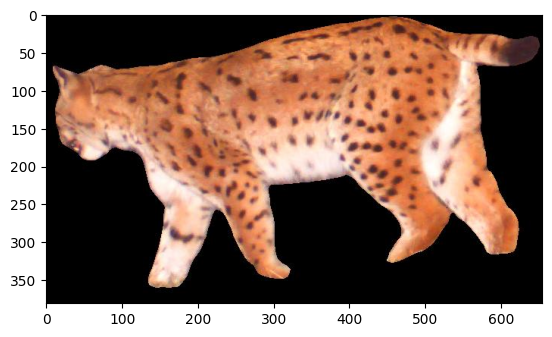

In [3]:
lynxDatasetNoBg = LynxDataset(Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv"), probabilities=[0, 0, 1])
lynxDatasetFull = LynxDataset(Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv"), probabilities=[1, 0, 0])
idx = 5

image = lynxDatasetNoBg[idx][0]['image']

plt.imshow(image)

print(image.shape)

## Luminosity / Contrast

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Moyenne du contraste: 0.5913643819821713
Écart-type du contraste: 0.19136722387195182


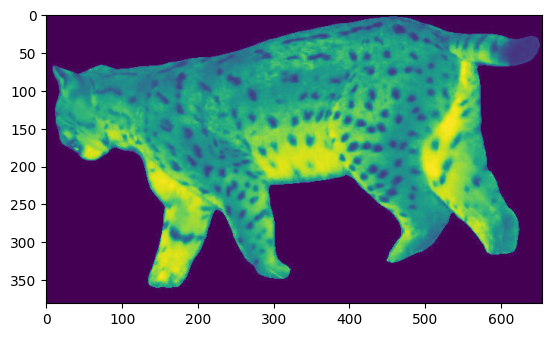

In [4]:
import numpy as np
from skimage import color

gray_image = color.rgb2gray(image)
plt.imshow(gray_image)

mask = np.all(image != [0, 0, 0], axis=-1)

mean_contrast = np.mean(gray_image[mask])
std_contrast = np.std(gray_image[mask])

print(f"Moyenne du contraste: {mean_contrast}")
print(f"Écart-type du contraste: {std_contrast}")

Low quality at index 1005, mean_constrat 0.07285561818069558, std_contrast 0.023910740436990294


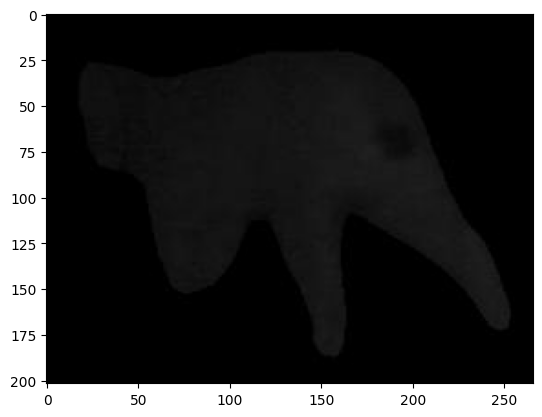

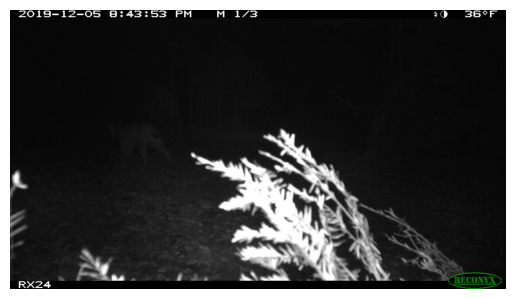

Low quality at index 1006, mean_constrat 0.08457541546107392, std_contrast 0.021105524844397268


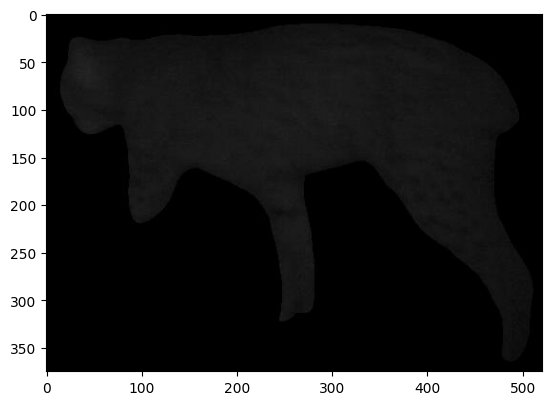

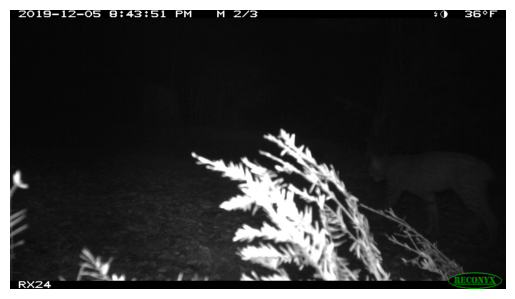

Low quality at index 1038, mean_constrat 0.9325229323072176, std_contrast 0.11932201821792476


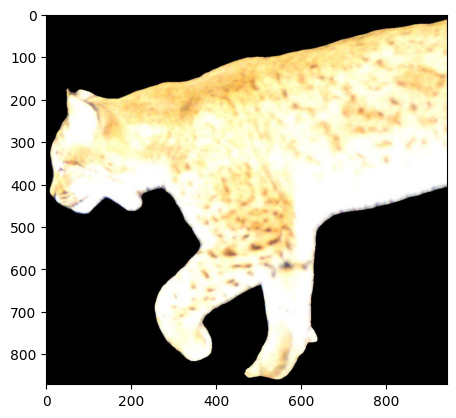

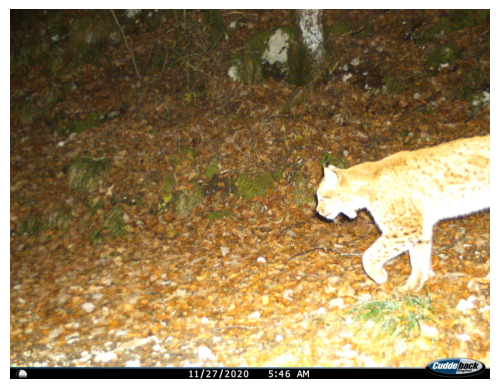

Low quality at index 1042, mean_constrat 0.9690721160483865, std_contrast 0.1057667961059168


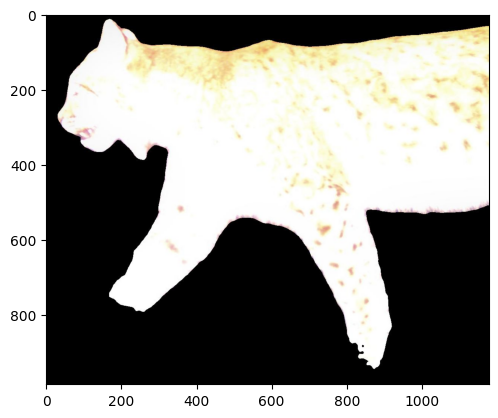

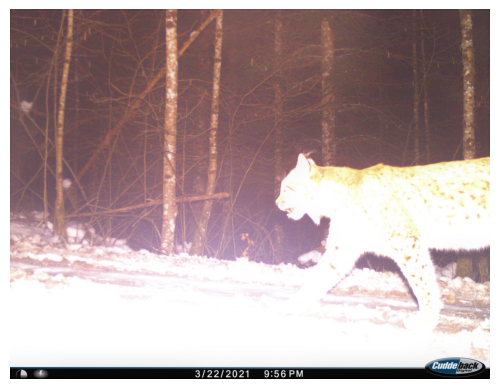

Low quality at index 1107, mean_constrat 0.9415191399326452, std_contrast 0.11398562789193209


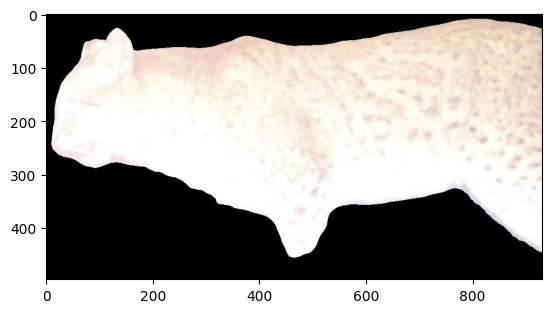

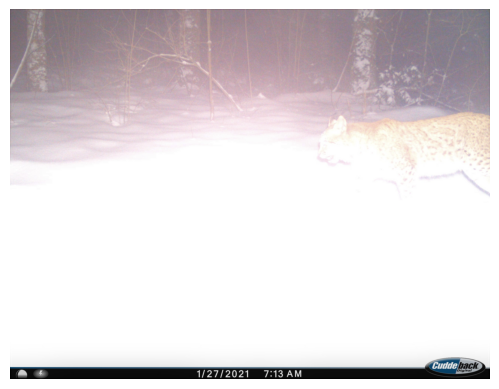

Low quality at index 1137, mean_constrat 0.9945878035443457, std_contrast 0.06381184353779853


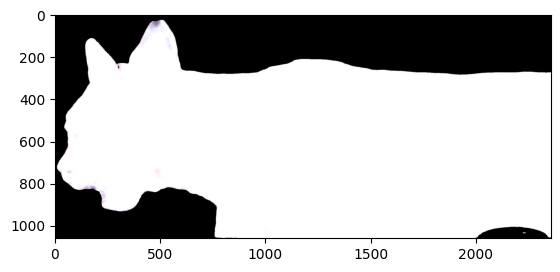

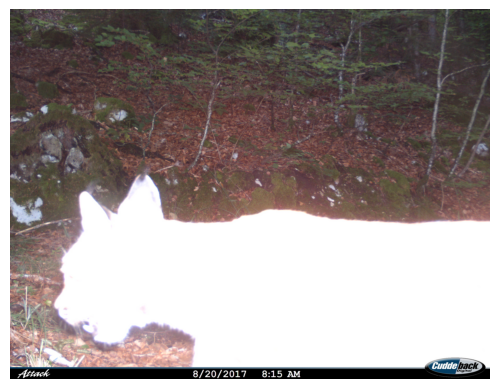

Low quality at index 1163, mean_constrat 0.9641254617661686, std_contrast 0.13139749993942312


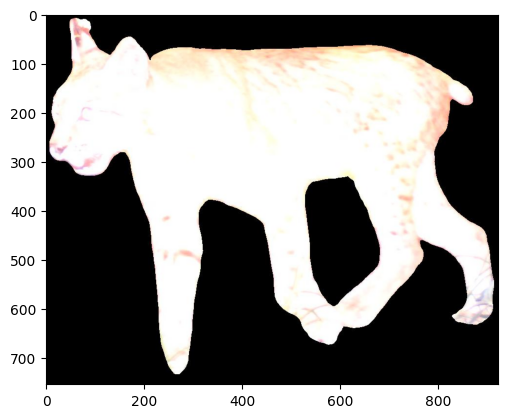

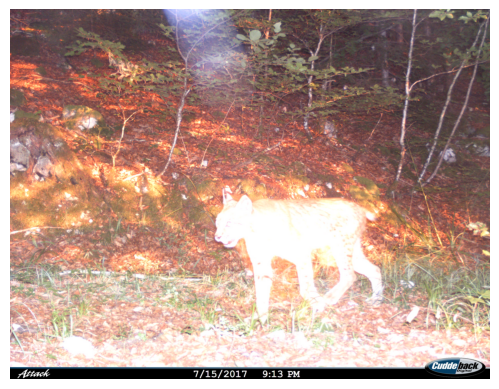

In [5]:
for i in range(1000, 1400):
    print(i, end="\r")
    image = lynxDatasetNoBg[i][0]['image']
    gray_image = color.rgb2gray(image)

    mask = np.all(image != [0, 0, 0], axis=-1)

    mean_contrast = np.mean(gray_image[mask])
    std_contrast = np.std(gray_image[mask])
    
    if not (0.1 <= mean_contrast <= 0.93):
        print(f"Low quality at index {i}, mean_constrat {mean_contrast}, std_contrast {std_contrast}")
        # lynxDataset[i][0]['filepath']
        plt.imshow(image)
        plt.show()
        plt.imshow(lynxDatasetFull[i][0]['image'])
        plt.axis('off')  # Turn off axis numbers and labels
        plt.show()

## Detection of the number of spots

(2001, 2900, 3)
nb pixels: 5802900


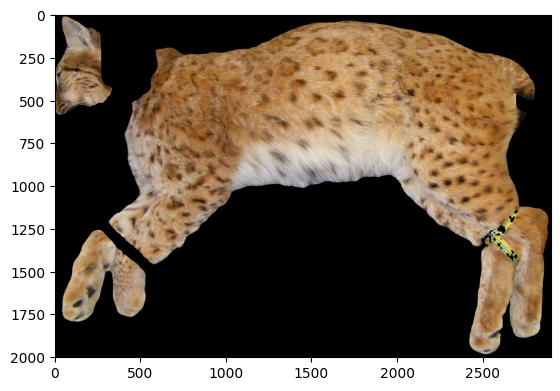

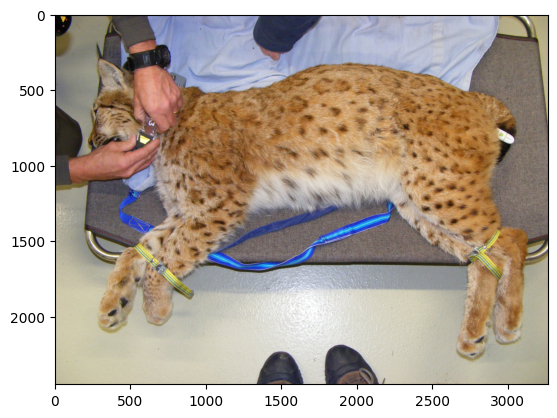

In [126]:
idx = 415
image = lynxDatasetNoBg[idx][0]['image']
image_full = lynxDatasetFull[idx][0]['image']

print(image.shape)
nb_pixels = image.shape[0] * image.shape[1]
print(f"nb pixels: {nb_pixels}")
plt.imshow(image)
plt.show()
plt.imshow(image_full)

### Resize images

`length` pixels width

0.3448275862068966
(690, 1000, 3)


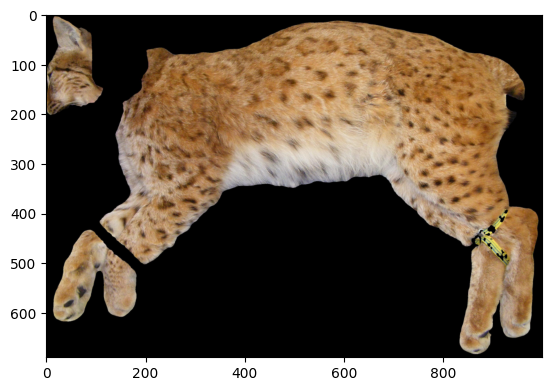

In [127]:
length = 1000


ratio = length / image.shape[1]
print(ratio)

new_width = int(image.shape[1] * ratio)
new_height = int(image.shape[0] * ratio)

# Redimensionner l'image avec OpenCV
image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
print(image.shape)
plt.imshow(image)

### Application of operations to binarise images and obtain tasks

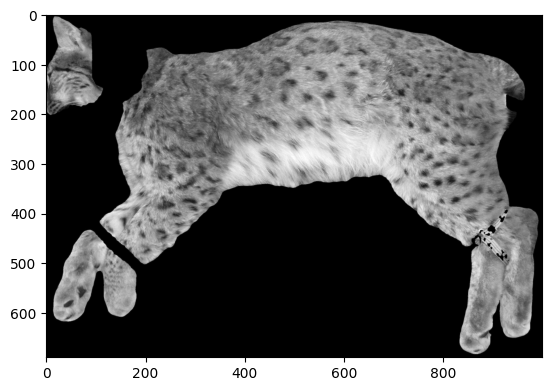

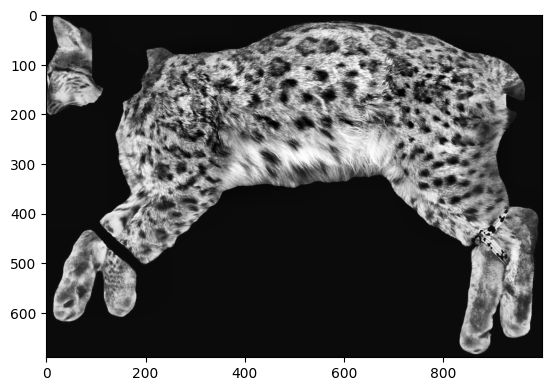

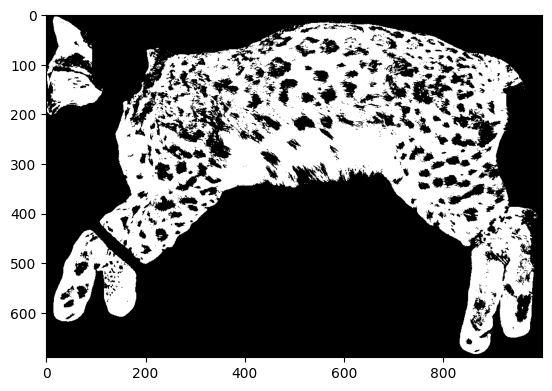

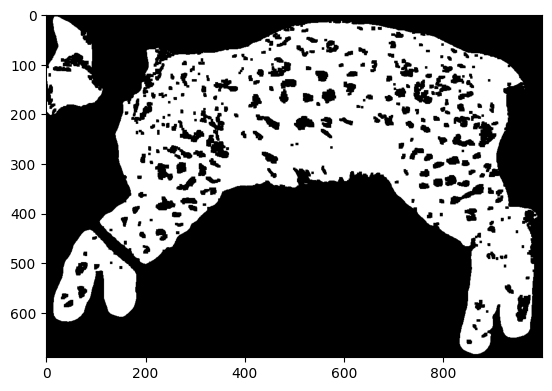

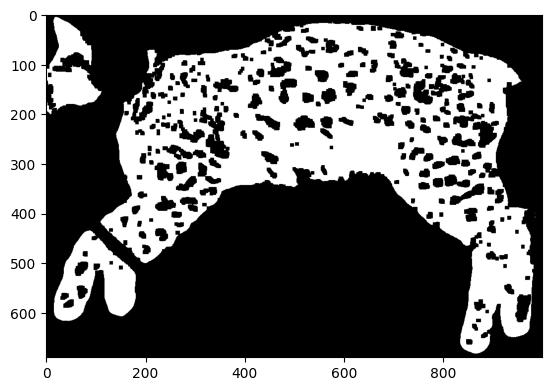

In [140]:
import cv2

# RGB to GRAY
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.show()

# Increased contrast with CLAHE
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
image_gray = clahe.apply(image_gray)
plt.imshow(image_gray, cmap="gray")
plt.show()

# Addition of blur (sometimes useful to reduce the number of spots detected)
# image_gray = cv2.GaussianBlur(image_gray,(3,3),0)
# plt.imshow(image_gray, cmap="gray")
# plt.show()

# Binarisation using the OTSU method or an adaptive threshold
t, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# binary_image = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 7)
plt.imshow(binary_image, cmap="gray")
plt.show()

# Closing operation : dilate (reduce black noise spots) and then erode (enlarge black spots)
kernel = np.ones((5, 5),np.uint8)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
plt.imshow(binary_image, cmap="gray")
plt.show()

# Erosion to reduce white space and therefore increase the size of spots (merge them)
kernel = np.ones((3, 3),np.uint8)
binary_image = cv2.erode(binary_image, kernel, iterations=1)
plt.imshow(binary_image, cmap="gray")

228


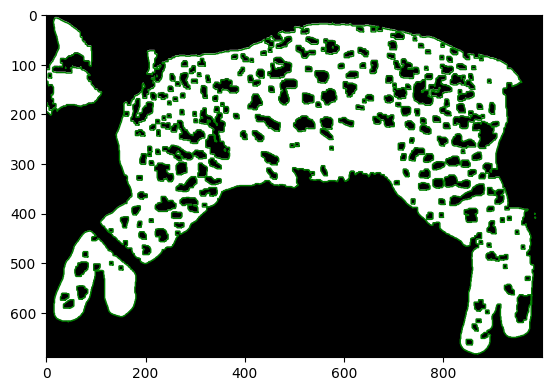

In [141]:
from skimage import measure

contours = measure.find_contours(binary_image, level=None, fully_connected="low", positive_orientation="low")
print(len(contours))

plt.imshow(binary_image, cmap="gray")
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')
plt.show()

### Loop

In [125]:
import os
prefix_save = "/gpfsscratch/rech/ads/commun/datasets/extracted/nb_spots_otsu_resize/"

length = 1000

for i in range(len(lynxDatasetNoBg)):
    print(i, end="\r")
    
    content = lynxDatasetNoBg[i][0]
    image = content['image']
    filepath = content['filepath']
    full_image = lynxDatasetFull[i][0]['image']
    
    ratio = length / image.shape[1]

    new_width = int(image.shape[1] * ratio)
    new_height = int(image.shape[0] * ratio)
    
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # image_gray = cv2.GaussianBlur(image_gray,(3,3),0)

    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    image_gray = clahe.apply(image_gray)

    t, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # binary_image = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 7)

    kernel = np.ones((5, 5),np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    kernel = np.ones((3, 3),np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=1)
    
    contours = measure.find_contours(binary_image, level=None, fully_connected="low", positive_orientation="low")
    
    path = prefix_save + '{:04d}'.format(len(contours)) + "_" + str(i) + "_" + os.path.basename(filepath)
    
    cv2.imwrite(path, full_image)

KeyboardInterrupt: 